Imports....

In [ ]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
from itertools import chain
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import trange
from time import sleep

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""Hyperparameters"""
LEARNING_RATE = 1e-4
BATCH_SIZE = 16
NUM_EPOCHS = 15
NUM_WORKERS = 2
IMG_HIGHT = 128
IMG_WIDTH = 128
IMG_CHANNEL = 3  
PIN_MEMORY = True
LOAD_MODEL = False

Data preprocessing....

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/stage1_train.zip" -d "/content"

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/stage1_test.zip" -d "/content"

In [ ]:
TRAIN_PATH =  'stage1_train/'
TEST_PATH  =  'stage1_test/'

In [ ]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [ ]:
X_train = np.zeros((len(train_ids), IMG_WIDTH , IMG_HIGHT , IMG_CHANNEL) , dtype = np.uint8)
Y_train = np.zeros((len(train_ids),IMG_WIDTH,IMG_HIGHT,1),dtype = np.bool)

In [ ]:
for n , id_ in tqdm(enumerate(train_ids) , total = len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[: , : , :IMG_CHANNEL]
    img = resize(img ,(IMG_HIGHT ,IMG_WIDTH) , mode='constant' , preserve_range = True)
    X_train[n] = img
    mask = np.zeros((IMG_HIGHT , IMG_WIDTH ,1) , dtype = np.bool)
    for i in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + i)
        mask_ = np.expand_dims(resize(mask_ , (IMG_HIGHT , IMG_WIDTH) , mode = 'constant' ,
                                      preserve_range = True), axis = -1)
        mask = np.maximum(mask , mask_)
    
    Y_train[n] = mask

100%|██████████| 670/670 [07:22<00:00,  1.52it/s]


In [ ]:
X_test = np.zeros((len(test_ids) , IMG_HIGHT , IMG_HIGHT , IMG_CHANNEL) , dtype = np.uint8)
sizes_test = []
print('resizing test')
for n , id_ in tqdm(enumerate(test_ids) , total = len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[: , : , :IMG_CHANNEL]
    img = resize(img ,(IMG_HIGHT ,IMG_WIDTH) , mode='constant' , preserve_range = True)
    X_test[n] = img

resizing test


100%|██████████| 65/65 [00:02<00:00, 29.31it/s]


In [ ]:
X_train.shape, Y_train.shape, X_test.shape

((670, 128, 128, 3), (670, 128, 128, 1), (65, 128, 128, 3))

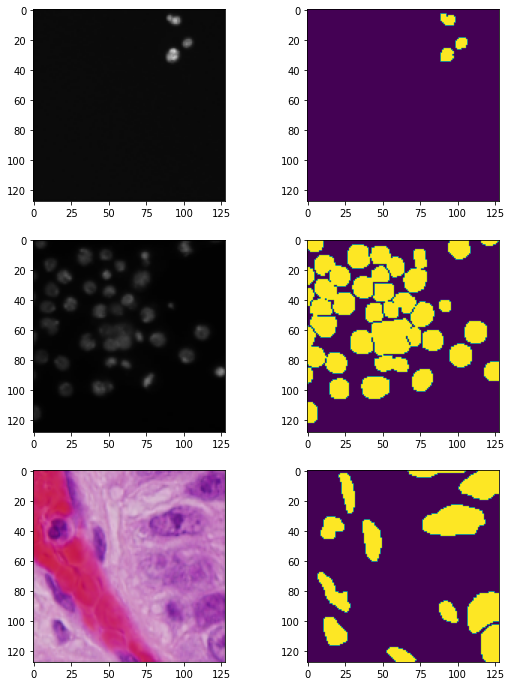

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(9,12))
ax[0][0].imshow(X_train[0])
ax[0][1].imshow(np.squeeze(Y_train[0]))
ax[1][0].imshow(X_train[1])
ax[1][1].imshow(np.squeeze(Y_train[1]))
ax[2][0].imshow(X_train[2])
ax[2][1].imshow(np.squeeze(Y_train[2]))

Dataloader....

In [ ]:
X_train, X_val, Y_train, Y_val =  train_test_split(X_train, Y_train, test_size=0.01)

In [ ]:
X_train = X_train.transpose((0,3,1,2))
Y_train = Y_train.transpose((0,3,1,2))
X_val = X_val.transpose((0,3,1,2))
Y_val = Y_val.transpose((0,3,1,2))
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((663, 3, 128, 128), (663, 1, 128, 128), (7, 3, 128, 128), (7, 1, 128, 128))

In [ ]:
X_train = torch.from_numpy(X_train)
Y_train = torch.from_numpy(Y_train)
X_val = torch.from_numpy(X_val)
Y_val = torch.from_numpy(Y_val)

In [ ]:
traindata = []
for i in range(len(X_train)):
  traindata.append([X_train[i], Y_train[i]])
trainloader = torch.utils.data.DataLoader(traindata, shuffle=True, batch_size=BATCH_SIZE)

In [ ]:
I,M = next(iter(trainloader))
print(T.shape, M.shape)

torch.Size([16, 3, 128, 128]) torch.Size([16, 1, 128, 128])


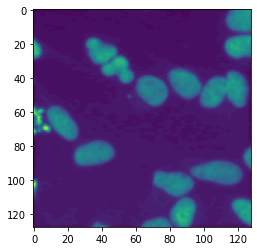

In [ ]:
plt.imshow(I[4][0])

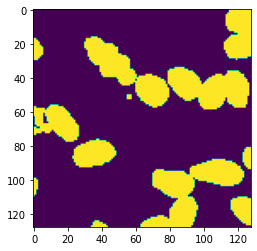

In [ ]:
plt.imshow(M[4][0])

In [ ]:
valdata = []
for i in range(len(X_val)):
  valdata.append([X_val[i], Y_val[i]])
valloader = torch.utils.data.DataLoader(valdata, shuffle=True, batch_size=BATCH_SIZE)

In [ ]:
IV,MV = next(iter(valloader))
print(IV.shape, MV.shape)

torch.Size([16, 3, 128, 128]) torch.Size([16, 1, 128, 128])


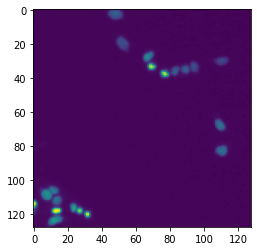

In [ ]:
plt.imshow(IV[4][0])

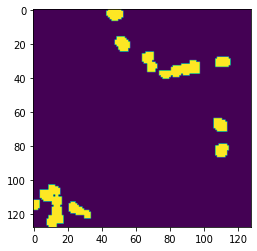

In [ ]:
plt.imshow(MV[4][0])

2D Unet model....

In [ ]:
class convolutional_blocks(nn.Module):
  def __init__(self, input_channels, output_channels):
    super().__init__()

    self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1)

    self.bn = nn.BatchNorm2d(output_channels)
    self.relu = nn.ReLU()
  
  def forward(self, inputs):
    x = self.conv1(inputs)
    x = self.bn(x)
    x = self.relu(x)

    x = self.conv2(x)
    x = self.bn(x)
    x = self.relu(x)

    return x

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_channels, output_channels):
    super().__init__()

    self.conv = convolutional_blocks(input_channels, output_channels).to(device)
    self.pooling = nn.MaxPool2d((2,2))

  def forward(self, inputs):
    x = self.conv(inputs) #x also acts as skip connection
    p = self.pooling(x) #p act as input for next encoder
    return x, p

In [ ]:
class Decoder(nn.Module):
  def __init__(self, input_channels, output_channels):
    super().__init__()

    self.up = nn.ConvTranspose2d(input_channels, output_channels, kernel_size=2, stride=2, padding=0)
    self.conv = convolutional_blocks(output_channels+output_channels, output_channels).to(device)

  def forward(self, inputs, skip):
    x = self.up(inputs)
    x = torch.cat([x, skip], axis=1)
    x = self.conv(x)
    return x

In [ ]:
class UNET(nn.Module):
  def __init__(self):
    super().__init__()

    """ Encoder part """
    self.e1 = Encoder(3,64).to(device)
    self.e2 = Encoder(64,128).to(device)
    self.e3 = Encoder(128,256).to(device)
    self.e4 = Encoder(256,512).to(device)

    """  Bottom line """
    self.bottom_line = convolutional_blocks(512,1024).to(device)

    """ Decoder """
    self.d1 = Decoder(1024,512).to(device)
    self.d2 = Decoder(512, 256).to(device)
    self.d3 = Decoder(256, 128).to(device)
    self.d4 = Decoder(128, 64).to(device)

    """ final layer """
    self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)
  
  def forward(self, inputs):
    skip_con1, p1 = self.e1(inputs)
    skip_con2, p2 = self.e2(p1)
    skip_con3, p3 = self.e3(p2)
    skip_con4, p4 = self.e4(p3)

    bottom_line = self.bottom_line(p4)

    d1 = self.d1(bottom_line, skip_con4)
    d2 = self.d2(d1, skip_con3)
    d3 = self.d3(d2, skip_con2)
    d4 = self.d4(d3, skip_con1)

    output = self.output(d4)

    return output

In [ ]:
# inputs = torch.randn((2,3,128,128)).to(device)
# print(inputs.shape)
# unet = UNET().to(device)
# output = unet(inputs)
# print(output.shape)

torch.Size([2, 3, 128, 128])
torch.Size([2, 1, 128, 128])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training pipeline....

In [ ]:
model = UNET().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

In [ ]:
def calc_loss(pred, target, bce_weight=0.6):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    return loss

In [ ]:
def imshow(imgs):
    imgs = torchvision.utils.make_grid(imgs)
    npimgs = imgs.cpu().numpy()
    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
def imshoww(imgs):
    imgs = torchvision.utils.make_grid(imgs)
    npimgs = imgs.cpu().numpy()
    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(npimgs, (1,2,0)))
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
for epoch in range(10):
  loss = 0.0
  for i, (images, masks) in enumerate(trainloader):
    images = images.float().to(device)
    masks = masks.float().to(device)
    optimizer.zero_grad()
    predictions = model(images)
    los = calc_loss(predictions, masks)
    los.backward()
    optimizer.step()

    loss += los.item()

  print('Epoch:{},   loss:{}'.format(epoch, loss/(i+1)))

  if epoch % 5 == 0:
    for j, (img,mask) in enumerate(valloader):
      with torch.no_grad():
        p = model(img.float().to(device))
        imshoww(img)
        imshow(p)
        if j == 0:
          break
    

Inference....

In [ ]:
X_test = X_test.transpose((0,3,1,2))
X_test = torch.from_numpy(X_test)

In [ ]:
# testdata = []
# for i in range(len(X_test)):
#   testdata.append([X_test[i]])
# testloader = torch.utils.data.DataLoader(testdata, shuffle=True, batch_size=BATCH_SIZE)

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(9,12))
ax[0][0].imshow(X_train[0])
ax[0][1].imshow(np.squeeze(Y_train[0]))
ax[1][0].imshow(X_train[1])
ax[1][1].imshow(np.squeeze(Y_train[1]))
ax[2][0].imshow(X_train[2])
ax[2][1].imshow(np.squeeze(Y_train[2]))

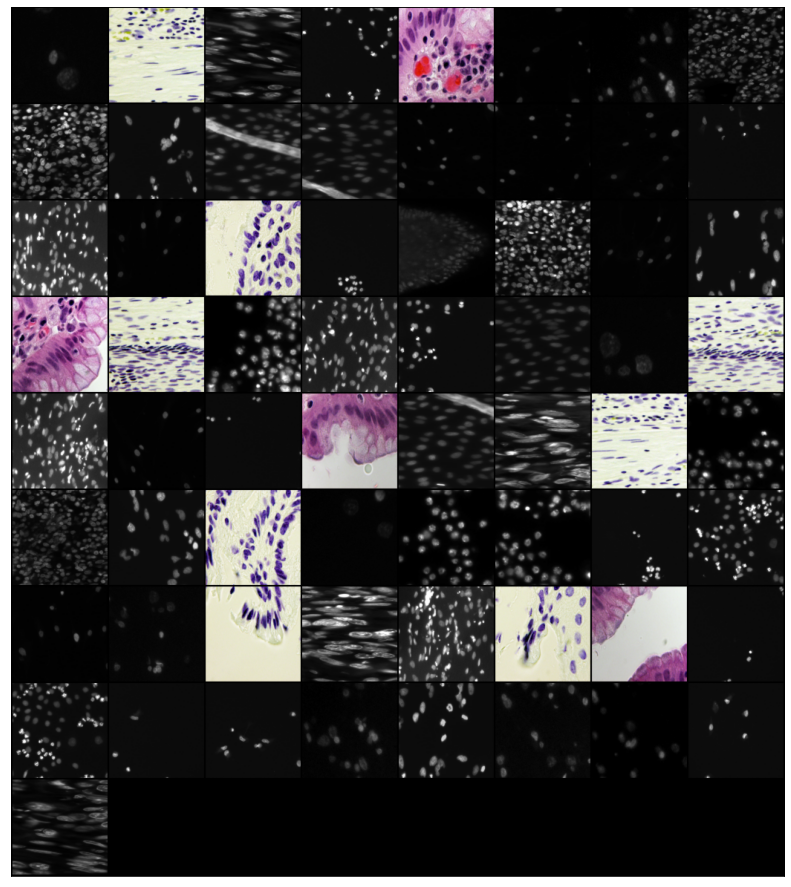

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


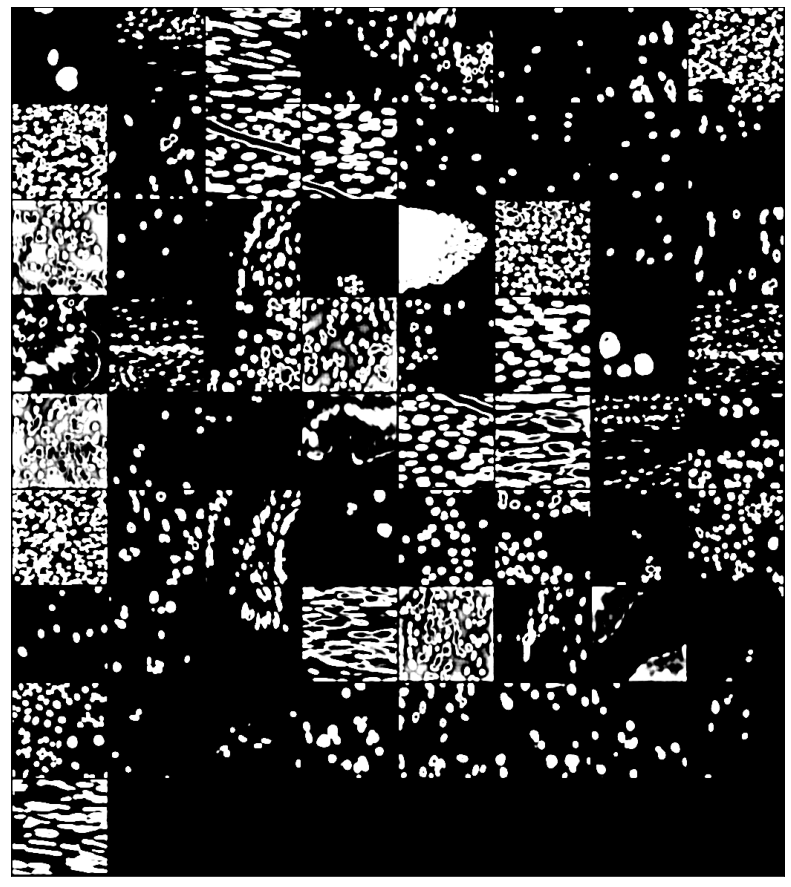

In [ ]:
model.eval()
with torch.no_grad():
  imshoww(X_test)
  masks = model(X_test.float().to(device))
  imshow(masks)